In [108]:
import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from collections import deque
import itertools
from uuid import uuid4
from time import sleep
from math import prod

In [109]:
def float_range(stop, start=0, step=1):
    while start < stop:
        yield float(start)
        start += step 

def tuple_eq(tup1,tup2):
    return len(set(tup1).union(set(tup2))) == len(tup1) == len(tup2)
    
def tuple_rev(tup):
    return (tup[1],tup[0])

def tuple_int(tup1,tup2):
    return len(set(tup1).union(set(tup2))) < len(tup1) + len(tup2)

identity_fn = lambda x: x
constant_fn = lambda x: lambda y: x
neg = lambda f: lambda x: -f(x)
sign = lambda x: 1 if x > 0 else -1 if x < 0 else 0

def euclidean_dist(node1,node2):
    return np.sqrt((node1.x-node2.x)**2 + (node1.y-node2.y)**2)

def manhattan_dist(node1,node2):
    return abs(node1.x-node2.x) + abs(node1.y-node2.y)




In [110]:
class Node:
    def __init__(self):
        self.x = None
        self.y = None
        self._weight = constant_fn(None)
        self.id = uuid4().hex    

    @property
    def weight(self):
        return self._weight(self)
    @weight.setter
    def weight(self, wf):
        if callable(wf):
            self._weight = wf
        elif isinstance(wf, (int,float)):
            self._weight = constant_fn(wf)
        else:
            raise TypeError('weight must be a function or a number')
    @property
    def loc(self):
        return (self.x,self.y)
    @loc.setter
    def loc(self, loc):
        self.x = loc[0]
        self.y = loc[1]
    @property
    def attr(self):
        return {'x':self.x,'y':self.y,'weight':self.weight}
    @attr.setter
    def attr(self, attr):
        for key in attr:
            if key == 'x':
                self.x = attr[key]
            if key == 'y':
                self.y = attr[key]
            if key == 'weight':
                self.weight = attr[key]
    
    def copy(self, keep_id = False):
        if keep_id:
            new = Node.make(self.x,self.y,self.weight)
            new.id = self.id
            return new
        return Node.make(self.x,self.y,self.weight)
    def __hash__(self) -> int:
        return hash(self.id)  
    def __eq__(self, o: object) -> bool:
        if isinstance(o, Node):
            return self.id == o.id
        return False 
    def __repr__(self) -> str:
        if self.x == None or self.y == None:
            return f'Node: ({self.x},{self.y})'
        string = f'Node: ({self.x:.2f},{self.y:.2f})'
        if not callable(self.weight) and self.weight != None:
            string += f'||weight {self.weight:.2f}'
        return string
    def __str__(self,show_weight = True) -> str:
        if self.x == None or self.y == None:
            return f'({self.x},{self.y})'
        string = f'({self.x:.2f},{self.y:.2f})'
        if self.weight != None and show_weight:
            string += f'||w {self.weight:.2f}'
        return string
    def __iter__(self):
        return iter(self.loc)
    def __getitem__(self, key):
        return self.loc[key]
    def __abs__(self):
        return np.sqrt(self.x**2 + self.y**2)
    def __contains__(self, item):        
        return item in self.loc
    
    @classmethod
    def make(cls, x, y, weight=constant_fn(None)):
        node = cls()
        node.x = x
        node.y = y
        node.weight = weight
        return node
    
    @staticmethod
    def dist(node1, node2, dist_fn = euclidean_dist):
        return dist_fn(node1,node2)
    
    def dist_to(self, node, dist_fn = euclidean_dist):
        return Node.dist(self, node, dist_fn)
    
    def move(self, loc_x, loc_y , rel = True):
        if rel:
            x = self.loc[0] + loc_x
            y = self.loc[1] + loc_y
            self.loc = (x,y)
        else:
            self.loc = (loc_x,loc_y)
            
    def move_function(self, fn_x, fn_y, t):
        self.loc = (fn_x(t),fn_y(t))

In [111]:
class Edge:
    def __init__(self, node1 = None, node2 = None):
        self.node1 = node1 if node1 != None else Node()
        self.node2 = node2 if node2 != None else Node()
        self._weight = constant_fn(None)
        self._dir = constant_fn(0)
        self.id = uuid4().hex

    @property
    def weight(self):
        return self._weight(self)
    @weight.setter
    def weight(self, wf):
        if callable(wf):
            self._weight = wf
        elif isinstance(wf, (int,float)):
            self._weight = constant_fn(wf)
        else:
            raise TypeError('weight must be a function or a number')

    @property
    def dir(self):
        return self._dir
    @dir.setter
    def dir(self, dir):
        if callable(dir):
            self._dir = dir
        elif isinstance(dir, (int)):
            if dir not in {0,1,-1}:
                raise ValueError('dir must be 0,1 or -1')
            self._dir = constant_fn(dir)
        else:
            raise TypeError('dir must be a function or the numbers 0,1 or -1')

    @property
    def nodes(self):
        return (self.node1,self.node2)
    @nodes.setter
    def nodes(self, nodes):
        self.node1 = nodes[0]
        self.node2 = nodes[1]
    @property
    def attr(self):
        return {'node1':self.node1,'node2':self.node2,'weight':self.weight,'dir':self.dir}
    @attr.setter
    def attr(self, attr):
        for key in attr:
            if key == 'node1':
                self.node1 = attr[key]
            if key == 'node2':
                self.node2 = attr[key]
            if key == 'weight':
                self.weight = attr[key]
            if key == 'dir':
                self.dir = attr[key]

    @property
    def node_ids(self):
        return (self.node1.id,self.node2.id)
    @property
    def node_locs(self):
        return (self.node1.loc,self.node2.loc)
    @node_locs.setter
    def node_locs(self, node_locs):
        self.node1.loc = node_locs[0]
        self.node2.loc = node_locs[1]
    @property
    def node_attrs(self):
        return (self.node1.attr,self.node2.attr)
    @node_attrs.setter
    def node_attrs(self, node_attrs):
        self.node1.attr = node_attrs[0]
        self.node2.attr = node_attrs[1]
    @property
    def node_weights(self):
        return (self.node1.weight,self.node2.weight)
    @node_weights.setter
    def node_weights(self, node_weights):
        self.node1.weight = node_weights[0]
        self.node2.weight = node_weights[1]
    
    @classmethod
    def make(cls, node1, node2, weight=constant_fn(None), dir=constant_fn(0)):
        edge = cls(node1, node2)
        edge.weight = weight
        edge.dir = dir
        return edge
    @classmethod
    def make_from_attr(cls, attr):
        return cls.make(attr['node1'], attr['node2'], attr['weight'], attr['dir'])
    def copy(self, keep_id=False):
        if keep_id:
            new_edge = Edge.make_from_attr(self.attr)
            new_edge.id = self.id
            return new_edge
        return Edge.make_from_attr(self.attr)
    def reversed(self, keep_id=True):
        if keep_id:
            self.dir = neg(self.dir)
            return self
        return Edge.make(self.node1, self.node2, self.weight, neg(self.dir))
    
    def __hash__(self) -> int:
        return hash(self.id)
    def __eq__(self, o: object) -> bool:
        if isinstance(o, Edge):
            return self.id == o.id
        return False
    def __repr__(self) -> str:
        if self.dir:
            string = f'Edge: {self.node1.__str__(False)} -> {self.node2.__str__(False)}'
        else:
            string = f'Edge: {self.node1.__str__(False)} -- {self.node2.__str__(False)}'
        if self.weight != None:
            string += f'||e_w {self.weight:.2f}'
        return string
    def __str__(self) -> str:
        return self.__repr__()
    def __iter__(self):
        return iter(self.nodes)
    def __getitem__(self, key):
        return self.nodes[key]
    def __abs__(self):
        return self.dist()
    def dist(self, dist_fn=Node.dist):
        return dist_fn(self.node1, self.node2)
    def __contains__(self, item):
        return item in self.nodes
    
    def other_node(self, node):
        if node == self.node1:
            return self.node2
        elif node == self.node2:
            return self.node1
        else:
            raise ValueError('node not in edge')
    def is_loop(self):
        return self.node1 == self.node2
    
    @staticmethod
    def compare_nodes_of_two_edges(edge1,edge2, reverse = False):
        if edge1.dir*edge2.dir == 1*(-1)**reverse:
            return edge1.nodes == edge2.nodes
        elif edge1.dir*edge2.dir == -1*(-1)**reverse:
            return edge1.nodes == tuple_rev(edge2.nodes)
        else:
            return tuple_eq(edge1.nodes,edge2.nodes)
        
    def is_parallel(self, edge):
        return Edge.compare_nodes_of_two_edges(self, edge)
        
    def is_reverse(self, edge):
        return Edge.compare_nodes_of_two_edges(self, edge, reverse=True)
    
    def is_incident(self, node):
        if sign(self.dir) == -1:
            return node == self.node1
        elif sign(self.dir) == 1:
            return node == self.node2
        return node in self.nodes
    
    

In [112]:
class Network:
    def __init__(self, nodes = None, edges = None):
        self.nodes = nodes if nodes else []
        self.edges = edges if edges else []
        self._node_translator = { node.id : node for node in self.nodes }
        self._edge_translator = { edge.id : edge for edge in self.edges }
        self._node_loc = { node.loc : node.id for node in self.nodes }
        self.adj = { node.id : 
                             { 
                              node.id : {
                                         'edge' : [], 'dir_edge' : []
                                        } for node in self.nodes
                             } for node in self.nodes }
        for edge in self.edges:
            self.adj[edge.node1.id][edge.node2.id]['edge'].append(edge.id)
            self.adj[edge.node2.id][edge.node1.id]['edge'].append(edge.id)
            if edge.dir == 1:
                self.adj[edge.node1.id][edge.node2.id]['dir_edge'].append(edge.id)
            elif edge.dir == -1:
                self.adj[edge.node2.id][edge.node1.id]['dir_edge'].append(edge.id)             
                
    def translate_node(self, id):
        return self._node_translator[id]
    def translate_nodes(self, ids):
        return list(map(self.translate_node, ids))
    def translate_edge(self, id):
        return self._edge_translator[id]
    def translate_edges(self, ids):
        return list(map(self.translate_edge, ids))
    def get_node(self, loc):
        return self._node_loc[loc]
    def get_edges(self, node1, node2, dir = False):
        if isinstance(node1, Node):
            node1 = node1.id
            node2 = node2.id
        elif isinstance(node1, tuple):
            node1 = self.get_node(node1)
            node2 = self.get_node(node2)
        elif isinstance(node1, str):
            pass
        else:
            raise ValueError('nodes must be type Node, tuple (loc), or str (id)')
        if dir:
            return list(map(self.translate_edge, self.adj[node1][node2]['dir_edge']))
        else:
            return list(map(self.translate_edge, self.adj[node1][node2]['edge']))

        
    @property
    def nodes(self):
        return self._nodes
    @nodes.setter
    def nodes(self, nodes):
        self._nodes = nodes
        self._node_translator = { node.id : node for node in self.nodes }
        self._node_loc = { node.loc : node.id for node in self.nodes }
        if len(self._node_loc) != len(self.nodes):
            raise ValueError('duplicate node locations')
        self.adj = { node.id : 
                             { 
                              node.id : {
                                         'edge' : [], 'dir_edge' : []
                                        } for node in self.nodes
                             } for node in self.nodes }   
        
    @property
    def edges(self):
        return self._edges
    @edges.setter
    def edges(self, edges):
        self._edges = edges
        self._edge_translator = { edge.id : edge for edge in self.edges }
        for edge in self.edges:
            if edge.node1.id not in self.adj or edge.node2.id not in self.adj:
                raise ValueError('edge nodes not in network')
            self.adj[edge.node1.id][edge.node2.id]['edge'].append(edge.id)
            self.adj[edge.node2.id][edge.node1.id]['edge'].append(edge.id)
            if edge.dir == 1:
                self.adj[edge.node1.id][edge.node2.id]['dir_edge'].append(edge.id)
            elif edge.dir == -1:
                self.adj[edge.node2.id][edge.node1.id]['dir_edge'].append(edge.id)
    @edges.deleter
    def edges(self):
        self._edges = []
        self._edge_translator = {}
        for node in self.nodes:
            self.adj[node.id] = { node.id : {
                                         'edge' : [], 'dir_edge' : []
                                        } for node in self.nodes }
    
    def __repr__(self,draw = False) -> str:
        if draw:
            self.draw()
        line_break = '=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-='
        return line_break + '\n' + \
                f"Network with {len(self.nodes)} Nodes and {len(self.edges)} Edges\n" + \
                line_break + '\n' + \
                'Nodes:\n' + '\n'.join([node.__repr__() for node in self.nodes]) + '\n' + \
                line_break + '\n' + \
                'Edges:\n' + '\n'.join([str(edge) for edge in self.edges]) + '\n'
    def __str__(self) -> str:
        return self.__repr__(draw=False)
    def __iter__(self):
        return iter(self.nodes)
    def __getitem__(self, key):
        if isinstance(key, int):
            return self.nodes[key]
        elif isinstance(key, str):
            return self._node_translator[key]
        elif isinstance(key, tuple):
            return self._node_translator[self._node_loc[key]]
        else:
            raise TypeError('key must be int, str (id), or tuple (loc)')
    def __len__(self):
        return len(self.nodes)
    def __contains__(self, item):
        return item in self.nodes or item in self.edges or item in self._node_translator or item in self._edge_translator
    def __eq__(self, __o: object) -> bool:
        if isinstance(__o, Network):
            self._node_translator == __o._node_translator and self._edge_translator == __o._edge_translator
        else:
            return False
    
    def add_node(self, node):
        if node not in self.nodes:
            if node.loc in self._node_loc:
                raise ValueError('duplicate node location')
            self.nodes.append(node)
            self._node_translator[node.id] = node
            self._node_loc[node.loc] = node.id
            self.adj.update({node.id : { node.id : {
                                         'edge' : [], 'dir_edge' : []
                                        } for node in self.nodes }})
            for node2 in self.nodes:
                self.adj[node2.id].update({node.id : {
                                         'edge' : [], 'dir_edge' : []
                                        }})
        else:
            raise ValueError('node already in network')        
    def add_edge(self, edge):
        if edge.node1 not in self.nodes and edge.node2 not in self.nodes:
            raise ValueError('nodes not in network')
        if edge not in self.edges:
            self.edges.append(edge)
            self._edge_translator[edge.id] = edge
            self.adj[edge.node1.id][edge.node2.id]['edge'].append(edge.id)
            self.adj[edge.node2.id][edge.node1.id]['edge'].append(edge.id)    
            if edge.dir == 1:
                self.adj[edge.node1.id][edge.node2.id]['dir_edge'].append(edge.id)
            elif edge.dir == -1:
                self.adj[edge.node2.id][edge.node1.id]['dir_edge'].append(edge.id)    
    def remove_node(self, node):
        if node in self.nodes:
            self.nodes.remove(node)
            del self._node_translator[node.id]
            del self.adj[node.id]
            del self._node_loc[node.loc]
            for node2 in self.nodes:
                del self.adj[node2.id][node.id]
            for edge in self.edges:
                if edge.node1 == node or edge.node2 == node:
                    self.remove_edge(edge)
        else:
            raise ValueError('node not in network')
    def remove_edge(self, edge):
        if edge in self.edges:
            self.edges.remove(edge)
            self.adj[edge.node1.id][edge.node2.id]['edge'].remove(edge.id)
            self.adj[edge.node2.id][edge.node1.id]['edge'].remove(edge.id)
            if edge.dir == 1:
                self.adj[edge.node1.id][edge.node2.id]['dir_edge'].remove(edge.id)
            elif edge.dir == -1:
                self.adj[edge.node2.id][edge.node1.id]['dir_edge'].remove(edge.id) 
        else:
            raise ValueError('edge not in network')
        
    def add_nodes(self, nodes):
        for node in nodes:
            self.add_node(node)
    def add_edges(self, edges):
        for edge in edges:
            self.add_edge(edge)
    def remove_nodes(self, nodes):
        for node in nodes:
            self.remove_node(node)
    def remove_edges(self, edges):
        for edge in edges:
            self.remove_edge(edge)
    
    def clear(self):
        self.nodes = []
        self.edges = []
        self._node_translator = {}
        self._edge_translator = {}
        self._node_loc = {}
        self.adj = {}
    def copy(self):
        copy_nodes = [node.copy() for node in self.nodes]
        copy_edges = [edge.copy() for edge in self.edges]
        return Network(copy_nodes, copy_edges)
    
    def change_node_weight(self, node, weight):
        try:
            node = self.translate_node(node)
        except:
            pass
        node.weight = weight
        
    def change_node_weights(self, weights):
        if isinstance(weights,(int,float,function)):
            for node in self.nodes:
                node.weight = weights
        elif isinstance(weights,dict):
            for node in self.nodes:
                node.weight = weights[node.id]
        else:
            raise TypeError('weights must be int, float, function, or dict')
    def change_edge_weight(self,edge,weight):
        try:
            edge = self.translate_edge(edge)
        except:
            pass
        edge.weight = weight
    def change_edge_dir(self,edge,dir):
        try:
            edge = self.translate_edge(edge)
        except:
            pass
        edge.dir = dir    
        
    def move_node(self, node, loc ,rel = False):
        try:
            node = self.translate_node(node)
        except:
            pass
        finally:
            del self._node_loc[node.loc]
        if rel:
            
            x = node.loc[0] + loc[0]
            y = node.loc[1] + loc[1]
            if (x,y) in self._node_loc:
                raise ValueError('duplicate node location')
            node.loc = (x,y)
            self._node_loc[node.loc] = node.id
        else:
            if loc in self._node_loc:
                raise ValueError('duplicate node location')
            node.loc = loc
            self._node_loc[node.loc] = node.id
    
    def reach(self, node, untranslated = False):
        try:
            node = node.id
        except:
            pass    
        visited = set()
        queue = deque([node])
        while queue:
            next = queue.popleft()
            visited.add(next)
            queue.extend([ids for ids in self.adj[next] if ids not in visited and self.adj[next][ids]['edge']])
        if untranslated:
            return visited
        return set(map(self.translate_node , visited))
    
    def subnetwork(self,node, dir = False):
        nodes = deque(self.reach(node,True))
        nodescopy = self.translate_nodes(nodes)
        edges =  []
        while nodes:
            next = nodes.popleft()
            if dir:
                 for i in self.adj[next].values():
                    for j in i['dir_edge']:
                        if j not in edges:
                            edges.append(j)
            else:
                for i in self.adj[next].values():
                    for j in i['edge']:
                        if j not in edges:
                            edges.append(j)

        
        return Network(nodescopy, [self.translate_edge(i) for i in edges])
    
    def subnetworks(self, dir = False):
        nodes = set(self.nodes)
        subnets = []
        while nodes:
            node = nodes.pop()
            subnet = self.subnetwork(node,dir)
            subnets.append(subnet)
            nodes = nodes - set(subnet.nodes)
        return subnets
    
    def is_connected(self):
        return len(self.subnetworks()) == 1
    
    def find_path(self, node1, node2, dir = False):
        try:
            node1 = node1.id
            node2 = node2.id
        except:
            pass
        if node1 == node2:
            return []
        visited = set()
        queue = deque([(node1,[])])
        while queue:
            next, path = queue.popleft()
            visited.add(next)
            path.append(next)
            if next == node2:
                return self.translate_nodes(path)
            queue.extend([(ids, path.copy()) for ids in self.adj[next] if ids not in visited and (dir or self.adj[next][ids]['edge'])])
        return None
    
    
    def find_path_heuristic(self, node1, node2, func, dir = False):
        try:
            node1 = node1.id
            node2 = node2.id
        except:
            pass
        if node1 == node2:
            return []
        visited = set()
        queue = deque([(node1,[])])
        while queue:
            next, path = queue.popleft()
            visited.add(next)
            path.append(next)
            if next == node2:
                return self.translate_nodes(path)
            queue.extend([(ids, path.copy()) for ids in self.adj[next] if ids not in visited and (dir or self.adj[next][ids]['edge'])])
            queue = deque(sorted(queue, key = lambda x: func(self.translate_node(x[0]))))
        return None
    
    def find_all_paths(self, node1, node2, dir = False):
        try:
            node1 = node1.id
            node2 = node2.id
        except:
            pass
        if node1 == node2:
            return []
        visited = set()
        queue = deque([(node1,[])])
        paths = []
        while queue:
            next, path = queue.popleft()
            visited.add(next)
            path.append(next)
            if next == node2:
                paths.append(self.translate_nodes(path))
            queue.extend([(ids, path.copy()) for ids in self.adj[next] if ids not in visited and (dir or self.adj[next][ids]['edge'])])
        return paths
    
    def sibling_paths(self, node1, node2, dir = False):
        try:
            node1 = node1.id
            node2 = node2.id
        except:
            pass
        if node1 == node2:
            return []
        visited = set()
        queue = deque([(node1,[])])
        paths = []
        while queue:
            next, path = queue.popleft()
            visited.add(next)
            path.append(next)
            if next == node2:
                paths.append(self.translate_nodes(path))
            queue.extend([(ids, path.copy()) for ids in self.adj[next] if ids not in visited and (dir or self.adj[next][ids]['edge'])])
        return paths
    
    def find_shortest_path(self, node1, node2, dir = False):
        try:
            node1 = node1.id
            node2 = node2.id
        except:
            pass
        if node1 == node2:
            return []
        visited = set()
        queue = deque([(node1,[])])
        while queue:
            next, path = queue.popleft()
            visited.add(next)
            path.append(next)
            if next == node2:
                return self.translate_nodes(path)
            queue.extend([(ids, path.copy()) for ids in self.adj[next] if ids not in visited and (dir or self.adj[next][ids]['edge'])])
            queue = deque(sorted(queue, key = lambda x: len(x[1])))
        return None
    
    def find_optimal_path(self, node1, node2, func, dir = False):
        try:
            node1 = node1.id
            node2 = node2.id
        except:
            pass
        if node1 == node2:
            return []
        visited = set()
        queue = deque([(node1,[])])
        while queue:
            next, path = queue.popleft()
            visited.add(next)
            path.append(next)
            if next == node2:
                return self.translate_nodes(path)
            queue.extend([(ids, path.copy()) for ids in self.adj[next] if ids not in visited and (dir or self.adj[next][ids]['edge'])])
            queue = deque(sorted(queue, key = lambda x: func(self.translate_nodes(x[1]))))
        return None
    
    

In [113]:
a = Node().make(1,5,1)
b = Node().make(2,4,2)
c = Node().make(3,3,3)
d = Node().make(4,2,4)
e = Node().make(5,1,5)
ab = Edge().make(a,b)
ac = Edge().make(a,c)
bd = Edge().make(b,d)
cd = Edge().make(c,d)
nodes = [a,b,c,d,e]
edges = [ab,ac,bd,cd]
network = Network(nodes, edges)
network

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Network with 5 Nodes and 4 Edges
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Nodes:
Node: (1.00,5.00)||weight 1.00
Node: (2.00,4.00)||weight 2.00
Node: (3.00,3.00)||weight 3.00
Node: (4.00,2.00)||weight 4.00
Node: (5.00,1.00)||weight 5.00
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Edges:
Edge: (1.00,5.00) -> (2.00,4.00)
Edge: (1.00,5.00) -> (3.00,3.00)
Edge: (2.00,4.00) -> (4.00,2.00)
Edge: (3.00,3.00) -> (4.00,2.00)

In [114]:
network.find_path(a,d)


[Node: (1.00,5.00)||weight 1.00,
 Node: (2.00,4.00)||weight 2.00,
 Node: (4.00,2.00)||weight 4.00]

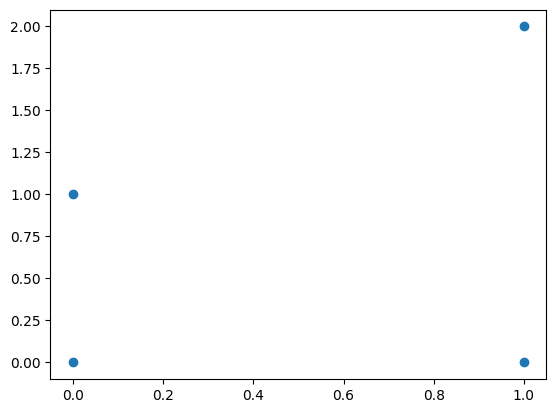

In [140]:
dist = lambda x : Node.dist(x.node1,x.node2)
a = Node().make(0,0)
b = Node().make(1,0)
c = Node().make(0,1)
d = Node().make(1,2)
ab = Edge().make(a,b,weight = lambda x :  dist(x))
ac = Edge().make(a,c,weight = lambda x :  dist(x))
bd = Edge().make(b,d,weight = lambda x :  dist(x))
cd = Edge().make(c,d,weight = lambda x :  dist(x))

network = Network([a,b,c,d],[ab,ac,bd,cd])
network
plt.scatter([i.loc[0] for i in network.nodes], [i.loc[1] for i in network.nodes])

In [151]:
ct = itertools.count(start=1)


3

In [152]:
edge_ids = [i.id for i in network.edges]
target_weights = {i: next(ct) for i in edge_ids}

In [153]:
def error(network):
    error_vector = [(i.weight - target_weights[i.id])**2 for i in network.edges]
    average_error = sum(error_vector)/len(error_vector)
    return average_error**0.5

dirs = {1:(1,0), 2:(0,1), 3:(-1,0), 4:(0,-1)}
node_memory = {node.id : {'cycle' : itertools.cycle(dirs.values()),
                          'back_counter' : 0} for node in network.nodes}

def cardinal_move(node,eps,weight):
    if node_memory[node.id]['back_counter'] > 3:
        return print(node, 'stuck')
    dir = next(node_memory[node.id]['cycle'])
    node.move(eps * dir[0], eps * dir[1], True)
    new_weight = error(network)
    if new_weight > weight:
        node.move(-eps * dir[0],- eps * dir[1], True)
        print('back')
        node_memory[node.id]['back_counter'] += 1
    else:
        node_memory[node.id]['back_counter'] = 0
        print('good')
    
    # dir = (1,0) -> (0,1) -> (-1,0) -> (0,-1) -> (1,0) -> ...

In [154]:
for i in range(1000):
    try:
        cardinal_move(a,0.01,error(network))
        cardinal_move(b,0.01,error(network))
        cardinal_move(c,0.01,error(network))
        cardinal_move(d,0.01,error(network))
    except:
        print('done',i)
        break

back
back
back
good
back
back
back
good
back
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good
good
good
good
back
good
good
good
back
back
back
back
good
back
back
back
good


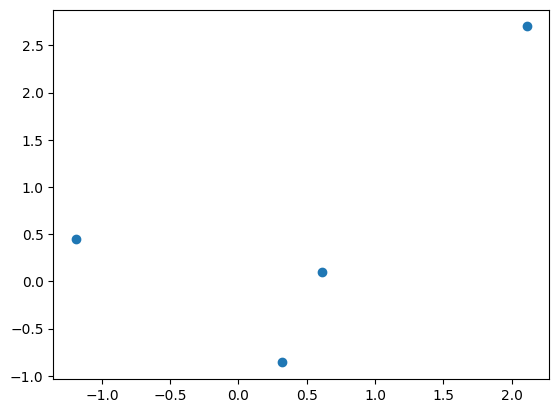

In [155]:
plt.scatter([i.loc[0] for i in network.nodes], [i.loc[1] for i in network.nodes])

In [156]:
network

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Network with 4 Nodes and 4 Edges
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Nodes:
Node: (0.32,-0.86)
Node: (0.61,0.10)
Node: (-1.19,0.45)
Node: (2.11,2.70)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Edges:
Edge: (0.32,-0.86) -> (0.61,0.10)||e_w 1.00
Edge: (0.32,-0.86) -> (-1.19,0.45)||e_w 2.00
Edge: (0.61,0.10) -> (2.11,2.70)||e_w 3.00
Edge: (-1.19,0.45) -> (2.11,2.70)||e_w 3.99

In [121]:
network, error(network)

(=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 Network with 4 Nodes and 4 Edges
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 Nodes:
 Node: (0.10,1.30)
 Node: (0.70,0.50)
 Node: (0.70,0.50)
 Node: (0.70,1.50)
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 Edges:
 Edge: (0.10,1.30) -> (0.70,0.50)||e_w 1.00
 Edge: (0.10,1.30) -> (0.70,0.50)||e_w 1.00
 Edge: (0.70,0.50) -> (0.70,1.50)||e_w 1.00
 Edge: (0.70,0.50) -> (0.70,1.50)||e_w 1.00,
 3.3306690738754696e-16)

In [122]:
next(node_memory[c.id])

TypeError: 'dict' object is not an iterator

In [ ]:
a.move((0.5,0),True)
error(network)

0.1380711874576983

In [ ]:
network

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Network with 3 Nodes and 3 Edges
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Nodes:
Node: (0.50,1.00)
Node: (1.00,0.00)
Node: (0.00,0.00)
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Edges:
Edge: (0.50,1.00) -- (1.00,0.00)||e_w 1.12
Edge: (0.50,1.00) -- (0.00,0.00)||e_w 1.12
Edge: (1.00,0.00) -- (0.00,0.00)||e_w 1.00

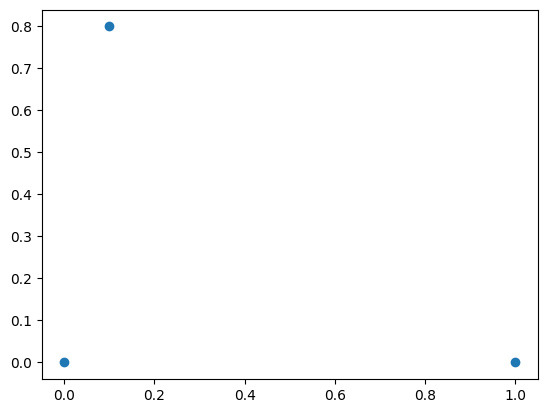

In [ ]:
class test:
    def __init__(self, func = None):
        self._a = 0
        self.func = func
        
    @property
    def a(self):
        return self._a
    @a.setter
    def a(self, value):
        if self.func:
            self._a = self.func(value)
        else:
            self._a = value

In [ ]:
x = test(lambda x : x**2)

In [ ]:
x.a = 5

In [ ]:
x.a

25

In [ ]:
next(x)

5